In [3]:
from qwak.qwak import QWAK
import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy.special as sp
from scipy.linalg import expm
import sympy as simp
import os


In [4]:
def write_nested_list_to_file(file_path, nested_lst):
    """
    Write a nested list of elements to a text file.
    
    :param file_path: the file path where to write the nested list
    :param nested_lst: the nested list of elements to write
    """
    with open(file_path, 'w') as f:
        for lst in nested_lst:
            for item in lst:
                f.write(f"{item} ")
            f.write("\n")

def load_nested_list_from_file(file_path):
    """
    Load a nested list of float elements from a text file.
    
    :param file_path: the file path to load the nested list from
    :return: the nested list of float elements loaded from the file
    """
    nested_lst = []
    with open(file_path, 'r') as f:
        for line in f:
            lst = [float(item) for item in line.strip().split()]
            nested_lst.append(lst)
    return nested_lst

def getWeightedGraph(graph,weight):
    revGraph = graph.reverse()
    for u,v,d in graph.edges(data=True):
        d["weight"] = weight
    for u,v,d in revGraph.edges(data=True):
        d["weight"] = np.conj(weight)
    return nx.compose(graph,revGraph)

def multiple_oriented_decayRate(N, k,fromNode, toNode, timeList, baseGraph, alphaList, initCond):
    decayRateMatrix = []
    for alpha in alphaList:
        weight = np.exp(1j * alpha)
        graph = getWeightedGraph(baseGraph, weight)
        qw = QWAK(graph)
        qw.runMultipleWalks(timeList=timeList, customStateList=initCond)
        decayRateMatrix.append(qw.getSurvivalProbList(fromNode,toNode))
    return decayRateMatrix

def plot_decay_rate_matrix(decay_rate_matrix, time_list, alpha_list, alpha_label_list=None,
                           title=None, xlabel='Time', ylabel='Decay Rate', legend_loc='best',
                           save_path=None, font_size=12,figsize=(10,6),
                           color_list=None, line_style_list=None):
    """
    Plots the decay rate matrix as a function of time for different alpha values.

    :param decay_rate_matrix: the decay rate matrix, a nested list of floats with shape (len(alpha_list), len(time_list))
    :param time_list: the list of time values at which the decay rate was calculated
    :param alpha_list: the list of alpha values used to generate the decay rate matrix
    :param alpha_label_list: optional list of labels for each alpha value (defaults to alpha_list)
    :param title: optional title for the plot
    :param xlabel: optional label for the x-axis
    :param ylabel: optional label for the y-axis
    :param legend_loc: optional legend location (defaults to 'best')
    :param save_path: optional path to save the plot (defaults to None, which shows the plot)
    :param font_size: optional font size for the plot (defaults to 12)
    :param figsize: optional tuple specifying the figure size (defaults to (10,6))
    :param color_list: optional list of colors to use for each alpha value (defaults to None)
    :param line_style_list: optional list of line styles to use for each alpha value (defaults to None)
    """

    # set default alpha labels
    if alpha_label_list is None:
        alpha_label_list = alpha_list

    # plot the decay rate for each alpha value
    fig, ax = plt.subplots(figsize=figsize)
    ax.loglog()
    ax.set_xlim([time_list[0], time_list[-1]])
    for i in range(len(alpha_list)):
        color = None
        line_style = None
        if color_list is not None:
            color = color_list[i]
        if line_style_list is not None:
            line_style = line_style_list[i]
        ax.plot(time_list, decay_rate_matrix[i], label=alpha_label_list[i], color=color, linestyle=line_style)

    # set the axis labels
    ax.set_xlabel(xlabel, fontsize=font_size+2)
    ax.set_ylabel(ylabel, fontsize=font_size+2)

    # set the plot title
    if title is not None:
        ax.set_title(title, fontsize=font_size+4)

    # set the legend
    legend =ax.legend(loc=legend_loc,ncol=len(alpha_list), fontsize=font_size-1)
    legend.set_title(r'$\alpha$', prop={'size': font_size - 1})

    # set font size for ticks
    ax.tick_params(axis='both', labelsize=font_size)
    fig.tight_layout()

    # save or show the plot
    if save_path is not None:
        plt.savefig(save_path)
        plt.show()
    else:
        plt.show()


In [5]:
n =  9
N = 2 ** n
print(N)

alpha = np.pi / 2
alphaList = [0, np.pi/ 3, np.pi/ 2 ]
print(alphaList)
alphaLabelList = [r'$0$', r'$\frac{\pi}{3}$', r'$\frac{\pi}{2}$']

baseGraph = nx.path_graph(N, create_using=nx.DiGraph)

k = 1
if k > 0:
    theta = np.pi / 4
else:
    theta = np.pi / 2

l = 0
gamma = l * np.pi

t = 100 
samples = 500
timeList = np.linspace(1, t, samples)
initCond = [(N // 2 - k, np.cos(theta)), (N // 2 + k, np.exp(1j * gamma) * np.sin(theta))]

fromNode = N // 2 - k - 1
toNode = N // 2 + k + 2

512
[0, 1.0471975511965976, 1.5707963267948966]


In [6]:
decayRateMatrix_file = f'Datasets/OrientedDecayRate/decayRateMatrix{N}_NWALKS{len(alphaList)}_S{samples}_TMAX{t}_FROM{fromNode}_TO{toNode}.txt'

if os.path.exists(decayRateMatrix_file):
    decayRateMatrix = load_nested_list_from_file(decayRateMatrix_file)
    print('File exists!')
    
else:
    print('File Doesnt Exist!')
    decayRateMatrix = multiple_oriented_decayRate(N,k,fromNode,toNode,timeList,baseGraph,alphaList,initCond)
    if not os.path.exists(decayRateMatrix_file):
        write_nested_list_to_file(decayRateMatrix_file, decayRateMatrix)


File exists!


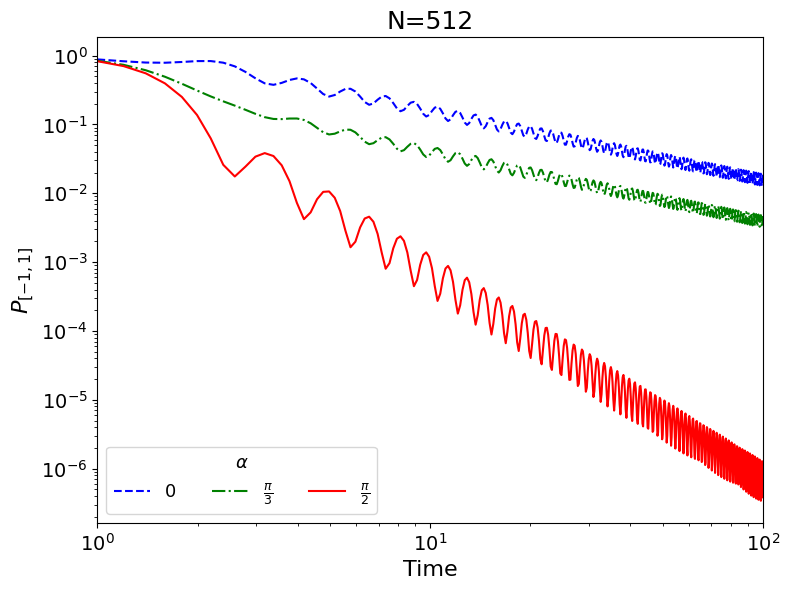

In [10]:
decayRateMatrix_output = f'Output/OrientedDecayRate/decayRateMatrix{N}_NWALKS{len(alphaList)}_S{samples}_TMAX{t}_FROM{fromNode}_TO{toNode}.png'

font_size = 14
figsize=(8, 6)
xlabel = 'Time'
ylabel = r"$P_{[-%s,%s]}$"%(k,k)
title = f'N={N}'
legend_loc = "lower left"

color_list = ['b','g','r']
line_style_list = ['--', '-.','-' ]

plot_decay_rate_matrix(decayRateMatrix, timeList, alphaList, alpha_label_list=alphaLabelList,
                       title=title,xlabel=xlabel, ylabel=ylabel, legend_loc=legend_loc,
                       save_path=decayRateMatrix_output, font_size=font_size,figsize=figsize,
                       color_list= color_list , line_style_list=line_style_list)

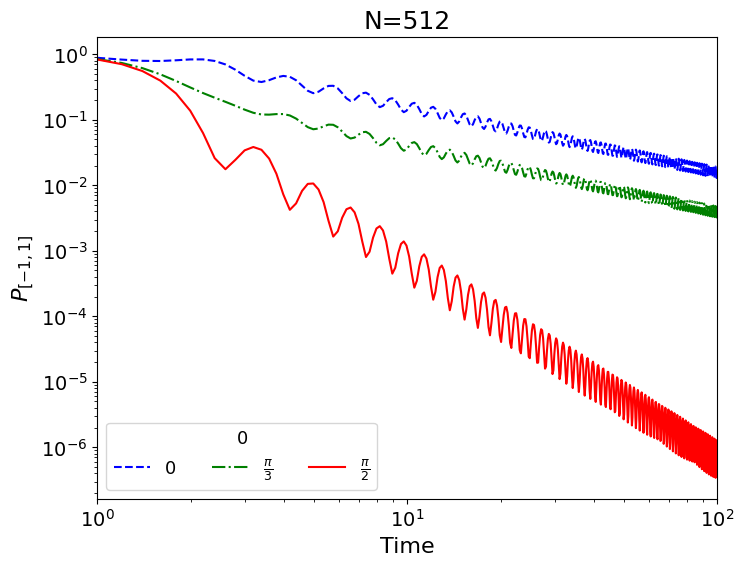

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import numpy as np

def plot_data(x_values, data_matrix, x_label=None, y_label=None, title=None, legend_labels=None, legend_loc='best',
              save_path=None, font_size=12, figsize=(10,6), color_list=None, line_style_list=None,
              use_loglog=False, use_cbar=False, cbar_label=None, cbar_ticks=None, cbar_tick_labels=None,
              x_num_ticks=None, y_num_ticks=None, x_round_val=3, y_round_val=3):

    # plot the data for each row of the data matrix
    fig, ax = plt.subplots(figsize=figsize)
    if use_loglog:
        ax.loglog()
    ax.set_xlim([x_values[0], x_values[-1]])
    i = 0
    for data in data_matrix:
        color = None
        line_style = None
        label = None
        if color_list is not None:
            color = color_list[i]
        if line_style_list is not None:
            line_style = line_style_list[i]
        if legend_labels is not None:
            label = legend_labels[i]
        ax.plot(x_values, data, label=label,
                color=color, linestyle=line_style)
        i+=1

    # set the axis labels
    if x_label is not None:
        ax.set_xlabel(x_label, fontsize=font_size+2)
    if y_label is not None:
        ax.set_ylabel(y_label, fontsize=font_size+2)

    # set the plot title
    if title is not None:
        ax.set_title(title, fontsize=font_size+4)

    # set the legend
    if legend_labels is not None:
        legend = ax.legend(loc=legend_loc,ncol=len(legend_labels), fontsize=font_size-1)
        if legend_labels[0] is not None:
            legend.set_title(legend_labels[0], prop={'size': font_size - 1})

    # set font size for ticks
    ax.tick_params(axis='both', labelsize=font_size)

    # set tick labels
    if x_num_ticks is not None:
        num_x_ticks = min(x_num_ticks, len(x_values))
        x_tick_labels = np.round(np.linspace(x_values[0], x_values[-1], num_x_ticks), x_round_val)
        ax.set_xticks(np.linspace(x_values[0], x_values[-1], num_x_ticks))
        ax.set_xticklabels(x_tick_labels)
    
    if y_num_ticks is not None:
        num_y_ticks = min(y_num_ticks, len(data_matrix[1]))
        y_tick_labels = np.round(np.linspace(data_matrix[0], data_matrix[-1], num_y_ticks), y_round_val)
        ax.set_yticks(np.linspace(data_matrix[0][0], data_matrix[-1][-1], num_y_ticks))
        ax.set_yticklabels(y_tick_labels)

    # add colorbar
    if use_cbar:
        colors = color_list or ['b', 'g', 'r', 'c', 'm', 'y', 'k']
        cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=len(colors))
        norm = BoundaryNorm(data_matrix, len(data_matrix)-1)

        if cbar_ticks is None:
            cbar_ticks = data_matrix

        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=cbar_ticks)
        if cbar_label is not None:
            cbar.set_label(cbar_label, fontsize=font_size + 2)
        cbar.ax.tick_params(labelsize=font_size)

    if cbar_tick_labels is not None:
        cbar.ax.set_yticklabels(cbar_tick_labels)

    # save or show the plot
    if save_path is not None:
        plt.savefig(save_path)
        plt.show()
    else:
        plt.show()
        
decayRateMatrix_output = f'Output/OrientedDecayRate/decayRateMatrix{N}_NWALKS{len(alphaList)}_S{samples}_TMAX{t}_FROM{fromNode}_TO{toNode}.png'

font_size = 14
figsize=(8, 6)
xlabel = 'Time'
ylabel = r"$P_{[-%s,%s]}$"%(k,k)
title = f'N={N}'
legend_loc = "lower left"

color_list = ['b','g','r']
line_style_list = ['--', '-.','-' ]

use_loglog = True
use_cbar = False
cbar_label = None 
cbar_ticks = None
cbar_tick_labels = None
x_num_ticks = None
y_num_ticks = None
x_round_val = 3
y_round_val = 3

plot_data(x_values = timeList, data_matrix = decayRateMatrix, x_label=xlabel, y_label=ylabel, title=title, legend_labels=alphaLabelList, legend_loc=legend_loc,
              save_path=decayRateMatrix_output, font_size=font_size, figsize=figsize, color_list=color_list, line_style_list=line_style_list,
              use_loglog=use_loglog, use_cbar=use_cbar, cbar_label=cbar_label, cbar_ticks=cbar_ticks, cbar_tick_labels=cbar_tick_labels,
              x_num_ticks=x_num_ticks, y_num_ticks=y_num_ticks, x_round_val=x_round_val, y_round_val=y_round_val)
